<a href="https://colab.research.google.com/github/masa512/ece558/blob/main/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.data import shepp_logan_phantom,camera
from skimage.transform import resize
from scipy.signal import sepfir2d, convolve
from scipy.ndimage import shift
N = 64 # pick whatever size
X = resize(shepp_logan_phantom(), (N,N))

# Problem 1

## PART A

In [ ]:
# Downsampled
Nccd = 4
h = np.array((Nccd+1)*[1]) # Basically ones in each dim but sepfir2d only works under odd N so just pad 1 for now
Y = sepfir2d(X,h,h)
Y = Y[::Nccd,::Nccd] # Downsample

Text(0.5, 1.0, 'CCD-Captured')

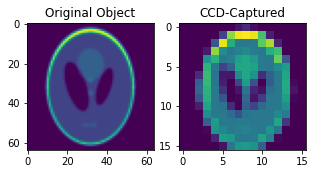

In [ ]:
f,axes = plt.subplots(1,2,figsize=(5,5))
axes[0].imshow(X)
axes[0].set_title('Original Object')

axes[1].imshow(Y)
axes[1].set_title('CCD-Captured')

## PART B

In [ ]:
# We will use a row major order method for the shifts we will apply
def ccd2(X,Nccd):
  h = np.array((Nccd+1)*[1]) # Basically ones in each dim but sepfir2d only works under odd N so just pad 1 for now
  Y = Nccd**2*[0]
  for dx in range(Nccd):
    for dy in range(Nccd):
      Y[Nccd*dy + dx] = sepfir2d(shift(X,[-dy,-dx],cval=0),h,h)[::Nccd,::Nccd].reshape(-1,)
  
  return np.array(Y)

(-0.5, 15.5, 15.5, -0.5)

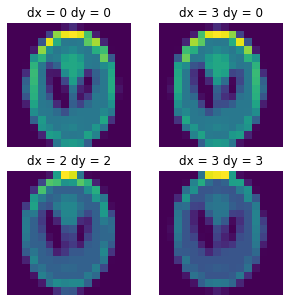

In [ ]:
# Use ccd2 for Nccd = 4
Nccd = 4
Nx = X.shape[0]
Y = ccd2(X,Nccd) # Nccd^2 by (Nx/Nccd)^2

# Print some examples
f,axes = plt.subplots(2,2,figsize=(5,5))
a = np.ravel(axes)

i = 0
a[0].imshow(Y[0].reshape(Nx//Nccd,Nx//Nccd))
a[0].set_title(f'dx = {i%Nccd} dy = {i//Nccd}')
a[0].axis('off')
i = 3
a[1].imshow(Y[i].reshape(Nx//Nccd,Nx//Nccd))
a[1].set_title(f'dx = {i%Nccd} dy = {i//Nccd}')
a[1].axis('off')

i = 10
a[2].imshow(Y[i].reshape(Nx//Nccd,Nx//Nccd))
a[2].set_title(f'dx = {i%Nccd} dy = {i//Nccd}')
a[2].axis('off')
i = 15
a[3].imshow(Y[i].reshape(Nx//Nccd,Nx//Nccd))
a[3].set_title(f'dx = {i%Nccd} dy = {i//Nccd}')
a[3].axis('off')

## PART C

In [ ]:
def dithermtx2(Nx,Nccd):
  # Create set of orthogonal vectors of length Nx * Nx
  ortho_set = np.diag(np.ones((Nx**2,)))

  # Now we will make a projection of each basis onto the dither set
  # Nx*Nx  by Nx*Nx (256 by 256)
  C = np.zeros((Nx*Nx,Nx*Nx))

  for i in range(ortho_set.shape[0]):
    # Sample each ortho image
    X = ortho_set[i,:].reshape(Nx,Nx)
    # Perform the 2D FIR Operation
    h = np.array((Nccd+1)*[1]) # Basically ones in each dim but sepfir2d only works under odd N so just pad 1 for now
    Y = sepfir2d(X,h,h)
    # We will reorder so that each partition of (Nx/Nccd)^2 is a particular dithered image
    # We will partition with each offset and stack
    Ci= [Y[k//Nccd::Nccd,k%Nccd::Nccd].reshape(-1,) for k in range(Nccd**2)]
    Ci = np.concatenate(Ci,axis=0)
    # Append to orthoset
    C[:,i] = Ci
  
  return C

In [ ]:
# We will now test the dithermtx2 on Nx = 64, and Nccd = 4
C = dithermtx2(64,4)

## PART D

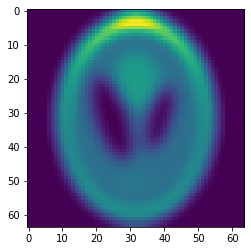

In [ ]:
# Reconstruction!
# 1. Stack the Part B dither set into vectors and apply the Adjoint of C to get x
y = Y.reshape(-1,)
x_pred = C.T @ y

plt.imshow(x_pred.reshape(Nx,Nx))

# Problem 2

## PART C

In [112]:
# convolution
class cgconvtik():
  def __init__(self,H,D1,D2,lmbd):
    self.H = H
    self.D1 = D1
    self.D1j = np.flip(D1,axis=0)
    self.D2 = D2
    self.D2j = np.flip(D2,axis=1)
    self.lmbd = lmbd

  def eval_A(self,Z):
    k1 = convolve(convolve(Z,self.H,'same'),self.H,'same')
    k2 = convolve(convolve(Z,self.D1j,'same'),self.D1,'same') + convolve(convolve(Z,self.D2j,'same'),self.D2,'same')
    return k1 + self.lmbd * k2
  
  def criterion(self,X,Xhat):
    # Simply use MSE
    error = np.mean(abs(X-Xhat)**2)
    return error

  def optimize(self,X0,Y,Nt,crit):
    # Only work with flattened vector unless applying convolution
    sx = X0.shape
    sy = Y.shape
    X = X0
    r = (convolve(Y,self.H,'same') - self.eval_A(X)).reshape(-1,)
    p = r

    for t in range(Nt):
      d = np.dot(p,self.eval_A(p.reshape(sx)).reshape(-1,))
      alp = np.dot(r,r)/d 
      Xn = X + alp*p.reshape(sx)
      rn = r - alp*self.eval_A(p.reshape(sx)).reshape(-1,)
      beta = np.dot(rn,rn)/np.dot(r,r)
      pn = rn + beta * p

      # Check convergence
      if self.criterion(self.eval_A(X),Y) <= crit:
        print(t)
        return Xn

      # Else, proceed
      X = Xn
      r = rn
      p = pn
    
    return X



## PART D

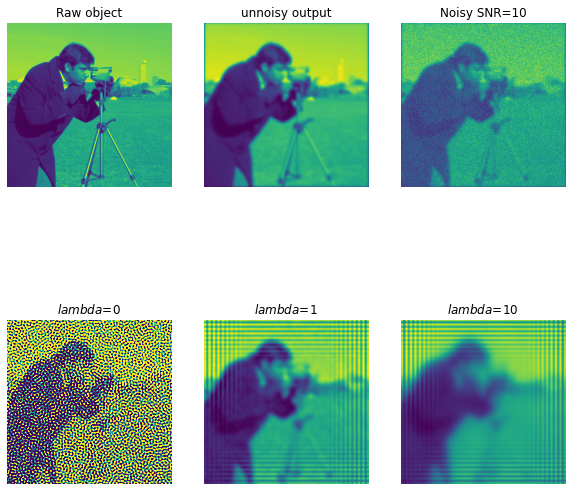

In [115]:
from scipy.signal.spectral import odd_ext
# Define Default function to return gaussian 2D kernel and define data as X
X = resize(camera(), (256,256))
def gauss2D(shape=(15,15),sigma=2): 
  """
  2D Gaussian kernel
  """
  m,n = [(ss-1.)/2. for ss in shape]
  y,x = np.ogrid[-m:m+1,-n:n+1]
  h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) ) 
  h[ h < np.finfo(h.dtype).eps*h.max() ] = 0 
  sumh = h.sum()
  if sumh != 0:
    h /= sumh
  return h

# Define the kernels for D1 and D2
def Dkernel(d1,d2):
  # Return the proper 2D kernel from d1 (vertical) and d2 (horizontal) lists
  D1 = np.array(d1).reshape(-1,1)
  D2 = np.array(d2).reshape(1,-1)

  return (D1,D2)

# Define noise function
def noise_up(Y,SNR):
  # Solve for sigma using the defined SNR
  std = (10**(-1/10*SNR)*np.var(Y))**(1/2)
  # Genrate gaussian noise
  N = np.random.normal(loc=0,scale=std,size=Y.shape)
  return N + Y


# Define kernel
d1 = [-1,0,1]
d2 = [-1,0,1]
D1,D2 = Dkernel(d1,d2)
H = gauss2D()

# Noise up the image
Y_clean = convolve(X,H,'same')
SNR = 10
Y_noisy = noise_up(Y_clean,SNR=SNR)

# Initiate the solver object
lmbds = [0,1,10] # Adjust this parameter
Xs = [] # List of outputs
Nt = 50 # Adjust this parameter
crit = 0.001 # MSE Criterion

for lmbd in lmbds:
  solver = cgconvtik(H,D1,D2,lmbd)
  o = solver.optimize(np.random.rand(Y_noisy.shape[0],Y_noisy.shape[1]),Y_noisy,Nt,crit)
  Xs.append(o)

# Plot the different outputs
f,axes = plt.subplots(2,3,figsize=(10,10))
a = np.ravel(axes)

a[0].imshow(X)
a[0].set_title('Raw object')

a[1].imshow(Y_clean)
a[1].set_title('unnoisy output')

a[2].imshow(Y_noisy)
a[2].set_title(f'Noisy SNR={SNR}')

a[3].imshow(Xs[0],vmin=0,vmax=1)
a[3].set_title(f'$lambda$={lmbds[0]}')

a[4].imshow(Xs[1],vmin=0,vmax=1)
a[4].set_title(f'$lambda$={lmbds[1]}')

a[5].imshow(Xs[2],vmin=0,vmax=1)
a[5].set_title(f'$lambda$={lmbds[2]}')

k = [axi.set_axis_off() for axi in a]

## PART E

In [128]:
# Radon
class cgtomtik():
  def __init__(self,theta,D1,D2,lmbd):
    self.theta = theta
    self.D1 = D1
    self.D1j = np.flip(D1,axis=0)
    self.D2 = D2
    self.D2j = np.flip(D2,axis=1)
    self.lmbd = lmbd

  def eval_A(self,Z):
    k1 =  iradon(radon(Z, theta=self.theta, circle=False), theta=self.theta, circle=False, filter_name=None)
    k2 = convolve(convolve(Z,self.D1j,'same'),self.D1,'same') + convolve(convolve(Z,self.D2j,'same'),self.D2,'same')
    return k1 + self.lmbd * k2
  
  def criterion(self,X,Xhat):
    # Simply use MSE
    error = np.mean(abs(X-Xhat)**2)
    return error

  def optimize(self,X0,Y,Nt,crit):
    # Only work with flattened vector unless applying convolution
    sx = X0.shape
    sy = Y.shape
    X = X0
    r = (iradon(Y, theta=self.theta, circle=False, filter_name=None) - self.eval_A(X)).reshape(-1,)
    p = r

    for t in range(Nt):
      d = np.dot(p,self.eval_A(p.reshape(sx)).reshape(-1,))
      alp = np.dot(r,r)/d 
      Xn = X + alp*p.reshape(sx)
      rn = r - alp*self.eval_A(p.reshape(sx)).reshape(-1,)
      beta = np.dot(rn,rn)/np.dot(r,r)
      pn = rn + beta * p

      # Check convergence
      if self.criterion(self.eval_A(X),iradon(Y, theta=self.theta, circle=False, filter_name=None)) <= crit:
        print(t)
        return Xn

      # Else, proceed
      X = Xn
      r = rn
      p = pn
    
    return X


## Part F

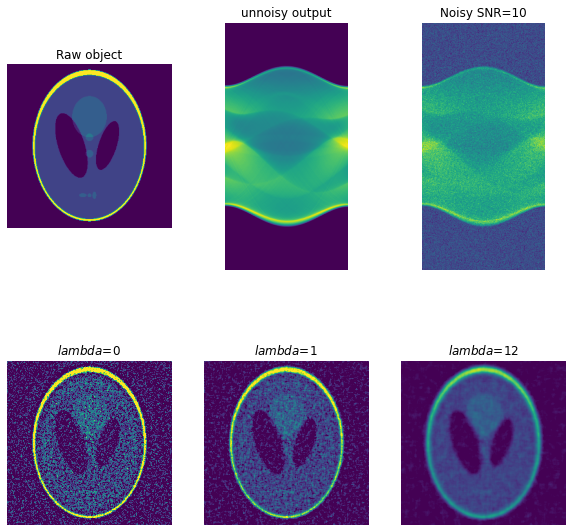

In [132]:
# Image
X = resize(shepp_logan_phantom(), (256,256))

# Define kernel
d1 = [-1,0,1]
d2 = [-1,0,1]
D1,D2 = Dkernel(d1,d2)

# Noise up the image
theta = np.arange(180)
Y_clean = radon(X, theta=theta, circle=False)
SNR = 10
Y_noisy = noise_up(Y_clean,SNR=SNR)

# Initiate the solver object
lmbds = [0,1,12] # Adjust this parameter
Xs = [] # List of outputs
Nt = 10 # Adjust this parameter
crit = 0.001 # MSE Criterion

for lmbd in lmbds:
  solver = cgtomtik(theta,D1,D2,lmbd)
  o = solver.optimize(np.random.rand(X.shape[0],X.shape[1]),Y_noisy,Nt,crit)
  Xs.append(o)

# Plot the different outputs
f,axes = plt.subplots(2,3,figsize=(10,10))
a = np.ravel(axes)

a[0].imshow(X)
a[0].set_title('Raw object')

a[1].imshow(Y_clean)
a[1].set_title('unnoisy output')

a[2].imshow(Y_noisy)
a[2].set_title(f'Noisy SNR={SNR}')

a[3].imshow(Xs[0],vmin=0,vmax=1)
a[3].set_title(f'$lambda$={lmbds[0]}')

a[4].imshow(Xs[1],vmin=0,vmax=1)
a[4].set_title(f'$lambda$={lmbds[1]}')

a[5].imshow(Xs[2],vmin=0,vmax=1)
a[5].set_title(f'$lambda$={lmbds[2]}')

k = [axi.set_axis_off() for axi in a]